# Actual and corrected run statistics

To do:
* Make a function with uses the age_speed_poly polynomial fit (continuous) rather than age_speed_table (discrete)
* Use fractional ages, rather than whole years
* Make a table of world records, and use this to create a polynomial fit called distance_worldrecord_poly
* Correct every run to equivalent mile time (using distance_worldrecord_poly)
* Correct every run to equivalent age-corrected mile time (using age_speed_poly)

In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

     MPH_diff
Age          
25       0.00
26       0.00
27       0.02
28       0.03
29       0.05
..        ...
86       6.74
87       7.02
88       7.30
89       7.59
90       7.87

[66 rows x 1 columns]
Index(['MPH_diff'], dtype='object')


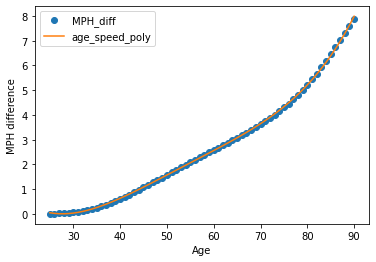

In [2]:
# According to tables from https://www.bigdatarunning.com, the most accurate age 
# adjustment to running times, may be based on a fixed decline in running speed 
# with age, across all distances

#age_speed_table = pd.read_csv('running_speed_decline.csv', index_col=0)
age_speed_table = pd.read_excel('/Users/gt/Dropbox/PERSONAL/Health_and_Fitness/Results/ALL_RACES_2021.xlsx', 'running_speed_decline', index_col=0)
age_speed_table.columns.str.lstrip()
print(age_speed_table)
age_speed_table.plot(label='age_speed_table', marker='o',linestyle='')
plt.ylabel('MPH difference')
print(age_speed_table.columns)

# Fit a polynomial at same x
age_speed_poly = np.polynomial.polynomial.Polynomial.fit(age_speed_table.index, age_speed_table['MPH_diff'], 4)
plt.plot(age_speed_table.index, age_speed_poly(age_speed_table.index), label='age_speed_poly')
plt.legend()

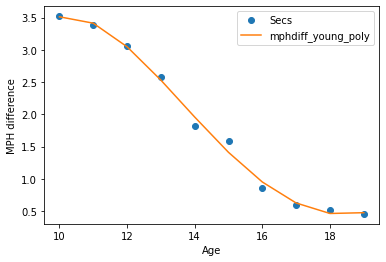

In [3]:
# Poly for ages below 20
#mile_world_records_young = pd.read_csv('mile_world_records_young.csv', index_col=0)
mile_world_records_young = pd.read_excel('/Users/gt/Dropbox/PERSONAL/Health_and_Fitness/Results/ALL_RACES_2021.xlsx', 'mile_world_records_teens', index_col=0)
mile_world_records_young.columns.str.lstrip()
# MPH difference
mph = 3600.0 /  mile_world_records_young['Secs']
mph_record = 3600 / 223.5
mphdiff = (mph_record-mph)
mphdiff_young_poly = np.polynomial.polynomial.Polynomial.fit(mphdiff.index, mphdiff, 4)
mphdiff.plot(marker='o',linestyle='')
plt.ylabel('MPH difference')
plt.plot(mphdiff.index, mphdiff_young_poly(mphdiff.index), label='mphdiff_young_poly')
plt.legend()

In [4]:
# Function based on the age_speed_table
def adjust_race_time_to_age_25(mphdiff_young_poly, age_speed_poly, age, miles, mins, secs):
    hours = mins/60 + secs/3600
    mph = miles / hours
    if age>25:
        mph_diff = age_speed_poly(age) #df[df.index==age][' MPH_diff']
    elif age<20:
        mph_diff = mphdiff_young_poly(age)
    else:
        mph_diff = 0.00
    mph_at_25 = mph + mph_diff
    fractional_minutes_at_25 = (miles * 60.0 / mph_at_25)
    minutes_at_25 = np.floor(fractional_minutes_at_25)
    seconds_at_25 = np.round(60.0*(fractional_minutes_at_25 - minutes_at_25))
    return (minutes_at_25, seconds_at_25)

In [5]:
# Read in the Master running spreadsheet
races = pd.read_excel('/Users/gt/Dropbox/PERSONAL/Health_and_Fitness/Results/ALL_RACES_2021.xlsx', 'RUN MASTER')

# Process each row, writing out corrected time & pace to a new file
corrected_file = 'corrected_race_results.csv'

myBirthday = datetime.datetime(1971,7,18,0,0,0,0)
badrows = []
with open(corrected_file, 'w') as f:
    f.write('Date,Age,Miles,Mins,Pace,Mins25,Pace25,Description,Age,comments\n')
    for i,row in races.iterrows():
        if not isinstance(row['Miles'], (float, int)):
            continue
        if not isinstance(row['Mins'], (float, int)):
            continue      
        if not isinstance(row['Secs'], (float, int)):
            continue
        if pd.isna(row['Miles']) or pd.isna(row['Mins']) or pd.isna(row['Secs']):
            continue
        if not isinstance(row['DESCRIPTION'], str):
            row['DESCRIPTION'] = ''
        if not isinstance(row['comments'], str):
            row['comments'] = ''


        age = relativedelta(row['DATE'], myBirthday)
        age_decimal_years = float(age.years)
        age_decimal_years += age.months / 12
        age_decimal_years += age.days / 365

        (mins25, secs25) = adjust_race_time_to_age_25(mphdiff_young_poly, age_speed_poly, age_decimal_years, float(row['Miles']), int(row['Mins']), int(row['Secs']) )
        decimal_mins = row['Mins']+row['Secs']/60
        decimal_mins25 = mins25+secs25/60
        pace = decimal_mins / row['Miles']
        pace25 = decimal_mins25 / row['Miles']
        f.write('%s, %2d, %6.3f, %6.2f, %5.2f, %6.2f, %5.2f, %s, %.2f, %s\n' % (row['DATE'].strftime('%Y-%m-%d'), age.years, row['Miles'], decimal_mins, pace, decimal_mins25, pace25, row['DESCRIPTION'].replace(',', ' '), age_decimal_years, row['comments'].replace(',',';')) )


Computing equivalent times for 100m
Computing equivalent times for 200m
Computing equivalent times for 400m
Computing equivalent times for 800m
Computing equivalent times for 1Mi
Computing equivalent times for 5k
Computing equivalent times for 5Mi
Computing equivalent times for 10k
Computing equivalent times for 15k
Computing equivalent times for 20k
Computing equivalent times for HMa
Computing equivalent times for 16.3
Computing equivalent times for Mar


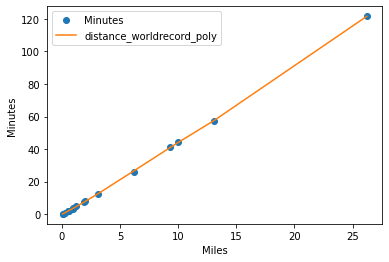

In [6]:
# Read in world record times
#worldrecs_table = pd.read_csv('worldrecords.csv', index_col=0)
worldrecs_table = pd.read_excel('/Users/gt/Dropbox/PERSONAL/Health_and_Fitness/Results/ALL_RACES_2021.xlsx', 'male_world_records', index_col=0)
worldrecs_table.columns.str.lstrip()
worldrecs_table.plot(label='worldrecs_table',marker='o',linestyle='')
plt.ylabel('Minutes')

# Fit a polynomial at same distances
distance_worldrecord_poly = np.polynomial.polynomial.Polynomial.fit(worldrecs_table.index, worldrecs_table['Minutes'], 4)
plt.plot(worldrecs_table.index, distance_worldrecord_poly(worldrecs_table.index), label='distance_worldrecord_poly')
plt.legend()

# Read the corrected file
corrected_races = pd.read_csv(corrected_file)
corrected_races.columns.str.lstrip()
corrected_races.dropna(inplace=True)

# Equivalent times at different distances
distances = [100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 5.0, 6.215, 9.3225, 12.43, 13.112, 16.3, 26.2]
labels = ['100m', '200m', '400m', '800m', '1Mi', '5k', '5Mi', '10k', '15k', '20k', 'HMa', '16.3', 'Mar']
for i, this_distance in enumerate(distances):
    this_label = labels[i]
    print('Computing equivalent times for %s' % this_label)
    columnname = 'eq_%s' % this_label
    columnname25 = 'eq25_%s' % this_label
    corrected_races[columnname]=corrected_races['Mins']/distance_worldrecord_poly(corrected_races['Miles']) * distance_worldrecord_poly(this_distance)
    corrected_races[columnname25]=corrected_races['Mins25']/distance_worldrecord_poly(corrected_races['Miles']) * distance_worldrecord_poly(this_distance)
    runsTooShort = corrected_races['Miles']<this_distance*0.93
    corrected_races.loc[runsTooShort, columnname]=None
    corrected_races.loc[runsTooShort, columnname25]=None
corrected_races.to_csv('equivalent_times.csv')

In [7]:
# My best equivalent times (at actual age) at each distance
for i, this_distance in enumerate(distances):
    this_label = labels[i]
    print('Ranking equivalent times for %s' % this_label)
    columnname = 'eq_%s' % this_label
    corrected_races.sort_values(by=[columnname], inplace=True)
    headdf = corrected_races[['Description','Date','Age','Miles',columnname]].head(100)
    #print(headdf)
    headdf.dropna(inplace=True)
    m = headdf[columnname]
    headdf['Minutes'] = np.round(np.fix((m - m % 1) / 1),0)   #to round towards 0
    s = (headdf[columnname] - headdf['Minutes']) * 60
    headdf['Seconds'] = np.round(np.fix((s - s % 1) / 1), 0)
    outfile = 'best_%s_performances.csv' % this_label
    headdf.to_csv(outfile)


Ranking equivalent times for 100m
Ranking equivalent times for 200m
Ranking equivalent times for 400m
Ranking equivalent times for 800m
Ranking equivalent times for 1Mi
Ranking equivalent times for 5k
Ranking equivalent times for 5Mi
Ranking equivalent times for 10k
Ranking equivalent times for 15k
Ranking equivalent times for 20k
Ranking equivalent times for HMa
Ranking equivalent times for 16.3
Ranking equivalent times for Mar


In [8]:
# My best equivalent age-corrected times at each distance
for i, this_distance in enumerate(distances):
    this_label = labels[i]
    print('Ranking equivalent times for %s corrected to age 25' % this_label)
    columnname = 'eq25_%s' % this_label
    corrected_races.sort_values(by=[columnname], inplace=True)
    headdf = corrected_races[['Description','Date','Age','Miles',columnname]].head(100)
    #print(headdf)
    headdf.dropna(inplace=True)
    m = headdf[columnname]
    headdf['Minutes'] = np.round(np.fix((m - m % 1) / 1),0)   #to round towards 0
    s = (headdf[columnname] - headdf['Minutes']) * 60
    headdf['Seconds'] = np.round(np.fix((s - s % 1) / 1), 0)
    outfile = 'best_%s_performances_age_corrected.csv' % this_label
    headdf.to_csv(outfile)


Ranking equivalent times for 100m corrected to age 25
Ranking equivalent times for 200m corrected to age 25
Ranking equivalent times for 400m corrected to age 25
Ranking equivalent times for 800m corrected to age 25
Ranking equivalent times for 1Mi corrected to age 25
Ranking equivalent times for 5k corrected to age 25
Ranking equivalent times for 5Mi corrected to age 25
Ranking equivalent times for 10k corrected to age 25
Ranking equivalent times for 15k corrected to age 25
Ranking equivalent times for 20k corrected to age 25
Ranking equivalent times for HMa corrected to age 25
Ranking equivalent times for 16.3 corrected to age 25
Ranking equivalent times for Mar corrected to age 25


In [9]:
# Interactive use of age adjustment to 25 years old

# Get inputs
print('User input:')
age = float(input('\tAge (in fractional years)'))
miles = float(input('\tDistance (in miles)'))
minsecs = input('\tRun time (minutes:seconds)').split(':')
mins = int(minsecs[0])
secs = int(minsecs[1])

# Compute
(mins25, secs25) = adjust_race_time_to_age_25(mphdiff_young_poly, age_speed_poly, age, miles, mins, secs)
print('time at age 25 = %d:%d' % (mins25, secs25))

User input:
	Age (in fractional years)50.3
	Distance (in miles)3.1075
	Run time (minutes:seconds)19:47
time at age 25 = 16:55


In [10]:
#### OLD STUFF FOLLOWS. IT WOULD BE GOOD TO RESURRECT THE PLOTS, ESP. by AGE

In [11]:
# Read the corrected file & make plots
corrected_races = pd.read_csv(corrected_file)
corrected_races.dropna(inplace=True)

KeyError: ' Miles'

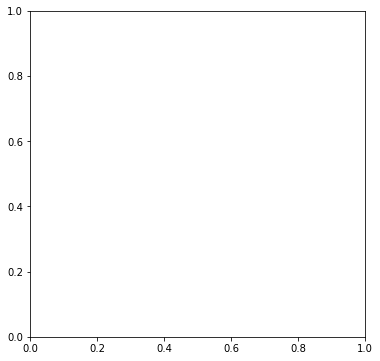

In [12]:
# Race pace
fix, ax = plt.subplots(figsize=(6, 6))
plt.semilogx(corrected_races[' Miles'], corrected_races[' Pace'], '.')
ax.set_xticks([100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 6.215, 13.1, 26.2])
#ax.set_yticks(np.arange(3, 11, 1))
ax.set_xticklabels(['100m', '200m', '400m', '800m', '1Mi', '5k', '10k', '1/2Ma', 'Ma'])
ax.set_ylabel('Race Pace (minutes per mile)')
ax.set_xlabel('Distance')
ax.grid()

# Race time
fix, ax = plt.subplots(figsize=(6, 6))
plt.semilogx(corrected_races[' Miles'], corrected_races[' Mins'], '.')
ax.set_xticks([100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 6.215, 13.1, 26.2])
#ax.set_yticks(np.arange(3, 11, 1))
ax.set_xticklabels(['100m', '200m', '400m', '800m', '1Mi', '5k', '10k', '1/2Ma', 'Ma'])
ax.set_ylabel('Race Time (minutes)')
ax.set_xlabel('Distance')
ax.grid()

# Corrected pace
fix, ax = plt.subplots(figsize=(6, 6))
plt.semilogx(corrected_races[' Miles'], corrected_races[' Pace25'], '.')
ax.set_xticks([100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 6.215, 13.1, 26.2])
#ax.set_yticks(np.arange(3, 11, 1))
ax.set_xticklabels(['100m', '200m', '400m', '800m', '1Mi', '5k', '10k', '1/2Ma', 'Ma'])
ax.set_ylabel('Corrected Pace (minutes per mile)')
ax.set_xlabel('Distance')
ax.grid()

# Corrected time
fix, ax = plt.subplots(figsize=(6, 6))
plt.semilogx(corrected_races[' Miles'], corrected_races[' Mins25'], '.')
ax.set_xticks([100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 6.215, 13.1, 26.2])
#ax.set_yticks(np.arange(3, 11, 1))
ax.set_xticklabels(['100m', '200m', '400m', '800m', '1Mi', '5k', '10k', '1/2Ma', 'Ma'])
ax.set_ylabel('Corrected Time (minutes)')
ax.set_xlabel('Distance')
ax.grid()

In [ ]:
# Read in world record times
worldrecs_table = pd.read_csv('worldrecords.csv', index_col=0)
worldrecs_table.plot(label='worldrecs_table')
plt.ylabel('Minutes')

# Fit a polynomial at same distances
distance_worldrecord_poly = np.polynomial.polynomial.Polynomial.fit(worldrecs_table.index, worldrecs_table[' Minutes'], 4)
plt.plot(worldrecs_table.index, distance_worldrecord_poly(worldrecs_table.index), label='distance_worldrecord_poly')
plt.legend()


In [ ]:
# Read the corrected file
corrected_races = pd.read_csv(corrected_file)
corrected_races.dropna(inplace=True)

# Correct all races back to equivalent mile time
corrected_races['equivalent_mile']=corrected_races[' Mins']/distance_worldrecord_poly(corrected_races[' Miles']) * distance_worldrecord_poly(1.0)
corrected_races['equivalent_mile25']=corrected_races[' Mins25']/distance_worldrecord_poly(corrected_races[' Miles']) * distance_worldrecord_poly(1.0

In [ ]:
# This graph effectively shows how good I am relative to world records
# For example, it suggests that given the shape I was in when I set my half-marathon PR in 2007, I could 
# have run one mile in about 5.5 minutes. I think I actually could have run a bit faster than that in 2007,
# and probably did, but this reflects that I am a better mile runner than half marathon runner, compared to
# world records at those distances.
fix, ax = plt.subplots(figsize=(6, 6))
plt.semilogx(corrected_races[' Miles'], corrected_races['mile_time'], '.')
ax.set_xticks([100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 6.215, 9.3225, 12.43, 13.1, 16.3, 26.2])
#ax.set_yticks(np.arange(3, 11, 1))
ax.set_xticklabels(['100m', '200m', '400m', '800m', '1Mi', '5k', '10k', '15k', '20k', '1/2Ma', '16.3', 'Ma'])
ax.set_ylabel('Equivalent mile time (minutes)')
ax.set_xlabel('Distance')
ax.grid()

In [ ]:
# This graph shows how good my performances have been through time. 
# It looks like my ability to run a 5 minute mile probably expired around 33.
# It would be easier to see if I filtered out distances below 1 mile in this plot and one above.
fix, ax = plt.subplots(figsize=(6, 6))
plt.plot(corrected_races[' Age'], corrected_races['mile_time'], '.')
ax.set_ylabel('Equivalent mile time (minutes)')
ax.set_xlabel('Age')
ax.grid()

In [ ]:
# Read in world record times
worldrecs_table = pd.read_csv('worldrecords.csv', index_col=0)
worldrecs_table.plot(label='worldrecs_table')
plt.ylabel('Minutes')

# Fit a polynomial at same distances
distance_worldrecord_poly = np.polynomial.polynomial.Polynomial.fit(worldrecs_table.index, worldrecs_table[' Minutes'], 4)
plt.plot(worldrecs_table.index, distance_worldrecord_poly(worldrecs_table.index), label='distance_worldrecord_poly')
plt.legend()

# Read the corrected file
corrected_races = pd.read_csv(corrected_file)
corrected_races.dropna(inplace=True)

# Equivalent times at different distances
distances = [100/1609, 200/1609, 400/1609, 800/1609, 1, 3.1075, 5.0, 6.215, 9.3225, 12.43, 13.112, 16.3, 26.2]
labels = ['100m', '200m', '400m', '800m', '1Mi', '5k', '5Mi', '10k', '15k', '20k', 'HMa', '16.3', 'Mar']
for i, this_distance in enumerate(distances):
    this_label = labels[i]
    print('Computing equivalent times for %s' % this_label)
    columnname = 'eq_%s' % this_label
    columnname25 = 'eq25_%s' % this_label
    corrected_races[columnname]=corrected_races[' Mins']/distance_worldrecord_poly(corrected_races[' Miles']) * distance_worldrecord_poly(this_distance)
    corrected_races[columnname25]=corrected_races[' Mins25']/distance_worldrecord_poly(corrected_races[' Miles']) * distance_worldrecord_poly(this_distance)
    runsTooShort = corrected_races[' Miles']<this_distance*0.93
    corrected_races.loc[runsTooShort, columnname]=None
    corrected_races.loc[runsTooShort, columnname25]=None
corrected_races.to_csv('equivalent_times.csv')
    

In [ ]:
# Let us loop over a set of distances, correct any longer runs (and up to 7% shorter) to that distance but eliminate shorter ones
distances = [1, 3.1075, 5.0, 6.215, 9.3225, 12.43, 13.1, 16.3, 26.2]
labels = ['100m', '200m', '400m', '800m', '1Mi', '5k', '10k', '15k', '20k', 'HMa', '16.3', 'Mar']
for this_distance in distances:
    min_distance = this_distance * 0.93 # this includes 1500m in mile comparisons
    
    # filter
    filtered_races = corrected_races[corrected_races[' Miles']>min_distance]
    
    # correct filtered_races to this_distance
    filtered_races['this_distance']=filtered_races[' Mins']/distance_worldrecord_poly(filtered_races[' Miles']) * distance_worldrecord_poly(this_distance)
    
    
    # print out the top 5
    filtered_races.sort_values(by=['this_distance'], inplace=True)
    #print(filtered_races)
    
    print('Best races at distance %f miles' % this_distance)
    print(filtered_races[0:5][['Date',' Age','this_distance',' Description']])

    """
    fix, ax = plt.subplots(figsize=(6, 6))
    plt.plot(filtered_races[' Age'], filtered_races['this_distance'], '.')
    ax.set_ylabel('Time (minutes)')
    ax.set_xlabel('Age')
    ax.grid()
    plt.show()
    """
    
    fix, ax = plt.subplots(figsize=(6, 6))
    best_by_age = filtered_races.groupby([' Age']).min()
    best_by_age['this_distance'].plot(marker='o', linestyle='',legend=False)
    
    
    
    #plt.plot(best_by_age[' Age'], best_by_age['this_distance'], '.')
    ax.set_ylabel('Time (minutes)')
    ax.set_xlabel('Age')
    ax.set_title('Distance %.4f miles' % this_distance)
    ax.grid()
    plt.show()    
    
    print(best_by_age)

    

In [ ]:
# Now let us do a similar thing, but plot all runs at each distance against age

In [ ]:
5.22/13*60/6.215

In [ ]:
# Let us loop over a set of distances, correct any longer runs (and up to 7% shorter) to that distance but eliminate shorter ones

distances = [1.0, 3.1075, 5.0, 6.215, 9.0, 13.1]
for this_distance in distances:
    min_distance = this_distance * 0.93 # this includes 1500m in mile comparisons
    
    # filter
    filtered_races = corrected_races[corrected_races[' Miles']>min_distance]
    
    # correct filtered_races to this_distance
    filtered_races['this_distance']=filtered_races[' Mins25']/distance_worldrecord_poly(filtered_races[' Miles']) * distance_worldrecord_poly(this_distance)
    
    
    # print out the top 5
    filtered_races.sort_values(by=['this_distance'], inplace=True)
    #print(filtered_races)
    
    print('Best races at distance %f miles' % this_distance)
    print(filtered_races[0:5][['Date',' Age','this_distance',' Description']])

    """
    fix, ax = plt.subplots(figsize=(6, 6))
    plt.plot(filtered_races[' Age'], filtered_races['this_distance'], '.')
    ax.set_ylabel('Time (minutes)')
    ax.set_xlabel('Age')
    ax.grid()
    plt.show()
    """
    
    fix, ax = plt.subplots(figsize=(6, 6))
    best_by_age = filtered_races.groupby([' Age']).min()
    best_by_age['this_distance'].plot(marker='o', linestyle='',legend=False)
    
    #plt.plot(best_by_age[' Age'], best_by_age['this_distance'], '.')
    ax.set_ylabel('Age-corrected time (minutes)')
    ax.set_xlabel('Age')
    ax.set_title('Distance %.4f miles' % this_distance)
    ax.grid()
    plt.show()    

In [ ]:
# Conclusions - how much am I slowing down?
# 1 mile: 3.93 s/mile/year
# 5k: 4.05 s/mile/year
# 10k: 3.87 s/mile/year

In [ ]:
mile_world_records_young = pd.read_csv('mile_world_records_young.csv', index_col=0)
mile_world_records_young.plot(marker='o',linestyle='')
plt.ylabel('Time (secs)')

# Fit a polynomial at same x
mile_world_records_young_poly = np.polynomial.polynomial.Polynomial.fit(mile_world_records_young.index, mile_world_records_young[' Secs'], 4)
plt.plot(mile_world_records_young.index, mile_world_records_young_poly(mile_world_records_young.index), label='mile_world_records_young_poly')
plt.legend()

In [ ]:
# Use that polynomial to age correct times before 20
15000/1609